# Programação Inteira Mista (MILP)

## Definição 

Dado $n$ variáveis contínuas $x\in\mathbb{R}^n$ e $m$ variáveis inteiras $y\in\mathbb{Z}^m$, um problema **MILP** é:

$$
\begin{aligned}
\min/\max \quad & c^\top x + d^\top y \\
\text{sujeito a} \quad
& A x + B y \le b,\\
& C x + D y = e,\\
& \ell_x \le x \le u_x,\quad \ell_y \le y \le u_y,\\
& x \in \mathbb{R}^n, y \in \mathbb{Z}^m.
\end{aligned}
$$

onde $A,B,C,D$ são matrizes reais, $b,e$ são vetores, $c,d$ são coeficientes da função-objetivo e $\ell_\cdot,u_\cdot$ são limites inferiores/superiores (podem ser finitos ou $\pm\infty$).

**Observações essenciais**

* O conjunto factível é a interseção de um poliedro com uma **rede inteira** (lattice), portanto **não convexo** em geral.
* O **relaxamento linear (LP)** resulta de substituir $y\in\mathbb{Z}^m$ por $y\in\mathbb{R}^m$; ele fornece limites $upper/lower bounds$ usados por algoritmos como **branch-and-bound**, **branch-and-cut** e **cutting planes**.
* MILP é **NP-difícil** no caso geral; casos especiais (ex.: matrizes totalmente unimodulares) têm relaxamento LP **integral**, tornando a solução do LP já ótima para o MILP.

Definição resumida
$$
\begin{aligned}
\max \quad & c^\top x + h^\top y \\
\text{st.} \quad & A x + G y \le b\\
& x\ge 0, \quad y\in\mathbb{Z}_+
\end{aligned}
$$
que é um caso particular da formulação geral acima. 


## Exemplo em $\mathbb{R}^2$:

$$
\begin{aligned}
\max \quad & x_1 + x_2 \\
\text{st.} \quad & x_1 + 2x_2 \leq 2 \\
           & 2x_1 + x_2 \leq 2 \\
           & 2x_1, x_2 \geq 0 \\
           & x_1\in\mathbb{R}_+,x_2\in\mathbb{Z}_+
\end{aligned}
$$

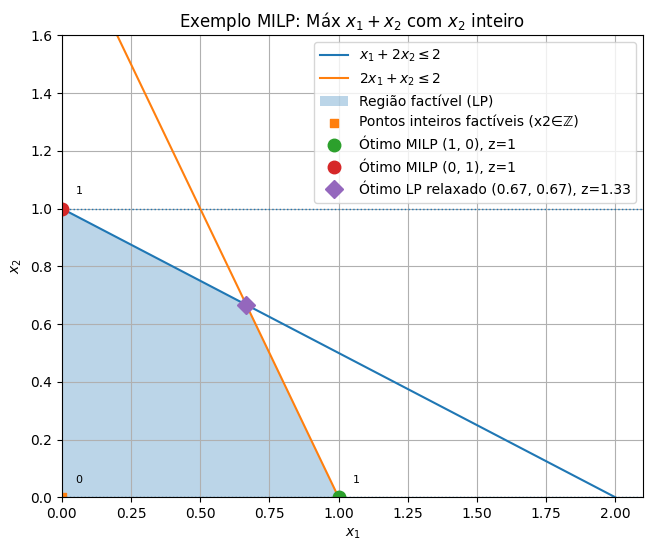

Ótimo LP relaxado: (0.6666666666666666, 0.6666666666666667) z = 1.3333333333333335
Ótimos MILP: [(1, 0, 1), (0, 1, 1)]


In [1]:
# MILP example from the slides: maximize x1 + x2 with one integer variable (x2)
# Constraints (as in the slides' figure that yields two MILP optima (1,0) and (0,1)):
#   x1 + 2 x2 <= 2
#   2 x1 + x2 <= 2
#   x1 >= 0, x2 >= 0
#   x2 is integer
#
# We'll show: LP relaxation optimum, MILP feasible integer points (for x2 in {0,1}),
# and highlight both optimal MILP solutions on a single didactic plot.

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# LP relaxation (both variables continuous)
c = [-1, -1]  # maximize x1+x2 -> minimize -(x1+x2)
A = [[1, 2], [2, 1]]
b = [2, 2]
bounds = [(0, None), (0, None)]
lp = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
x_lp = lp.x
z_lp = x_lp.sum()

# MILP: x2 integer. Here constraints imply x2 in {0,1} (since x1>=0 and x1+2x2 <= 2).
milp_feasible = []
opt_val = -np.inf
opt_points = []

for x2 in [0, 1]:
    # For fixed integer x2, maximize x1 + x2 subject to:
    #   x1 <= 2 - 2 x2      (from x1 + 2x2 <= 2)
    #   x1 <= (2 - x2) / 2  (from 2x1 + x2 <= 2)
    #   x1 >= 0
    ub1 = 2 - 2 * x2
    ub2 = (2 - x2) / 2
    x1_max = max(0.0, min(ub1, ub2))

    # Feasible integer x1 values on this horizontal line (didactic markers):
    # limit integers to a small safe range
    for x1_int in range(0, 3):
        if x1_int <= ub1 + 1e-9 and x1_int <= ub2 + 1e-9:
            milp_feasible.append((x1_int, x2, x1_int + x2))

    # Optimal continuous x1 at this fixed x2 (since objective is increasing in x1)
    z_here = x1_max + x2
    if z_here > opt_val - 1e-12:
        if abs(z_here - opt_val) <= 1e-12:
            opt_points.append((x1_max, x2, z_here))
        else:
            opt_val = z_here
            opt_points = [(x1_max, x2, z_here)]

# Prepare plot
x = np.linspace(0, 2.1, 400)
y1 = (2 - x) / 2   # from x1 + 2 x2 <= 2
y2 = 2 - 2 * x     # from 2 x1 + x2 <= 2
y = np.minimum(y1, y2)

plt.figure(figsize=(7.5, 6))

# Constraint lines
plt.plot(x, y1, label=r"$x_1 + 2x_2 \leq 2$")
plt.plot(x, y2, label=r"$2x_1 + x_2 \leq 2$")

# Feasible region (LP relaxation)
y_fill = np.clip(y, 0, None)
plt.fill_between(x, 0, y_fill, where=y_fill>=0, alpha=0.3, label="Região factível (LP)")

# Integer horizontal lines for x2 in {0,1}
for xi in [0, 1]:
    plt.axhline(y=xi, linestyle=":", linewidth=1)

# MILP feasible integer points
if milp_feasible:
    pts = np.array([(a, b) for a, b, _ in milp_feasible])
    plt.scatter(pts[:, 0], pts[:, 1], marker="s", s=40, label="Pontos inteiros factíveis (x2∈ℤ)")
    # annotate objective values
    for (a, b, z) in milp_feasible:
        plt.text(a + 0.05, b + 0.05, f"{z}", fontsize=8)

# MILP optimal points (there are two: (1,0) and (0,1))
for (a, b, z) in opt_points:
    # Round visually to nearest integer for display if it's close (should be exact here)
    a_disp = round(a, 10)
    b_disp = round(b, 10)
    plt.plot(a_disp, b_disp, marker="o", markersize=9, linestyle="None",
             label=f"Ótimo MILP ({int(a_disp)}, {int(b_disp)}), z={int(z)}")

# LP relaxation optimum
plt.plot(x_lp[0], x_lp[1], marker="D", markersize=9, linestyle="None",
         label=f"Ótimo LP relaxado ({x_lp[0]:.2f}, {x_lp[1]:.2f}), z={z_lp:.2f}")

plt.xlim(0, 2.1)
plt.ylim(0, 1.6)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Exemplo MILP: Máx $x_1 + x_2$ com $x_2$ inteiro")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Print numeric summary
print("Ótimo LP relaxado:", (float(x_lp[0]), float(x_lp[1])), "z =", float(z_lp))
print("Ótimos MILP:", [ (int(round(a)), int(round(b)), int(round(z))) for a,b,z in opt_points ])
